## SVM regresija

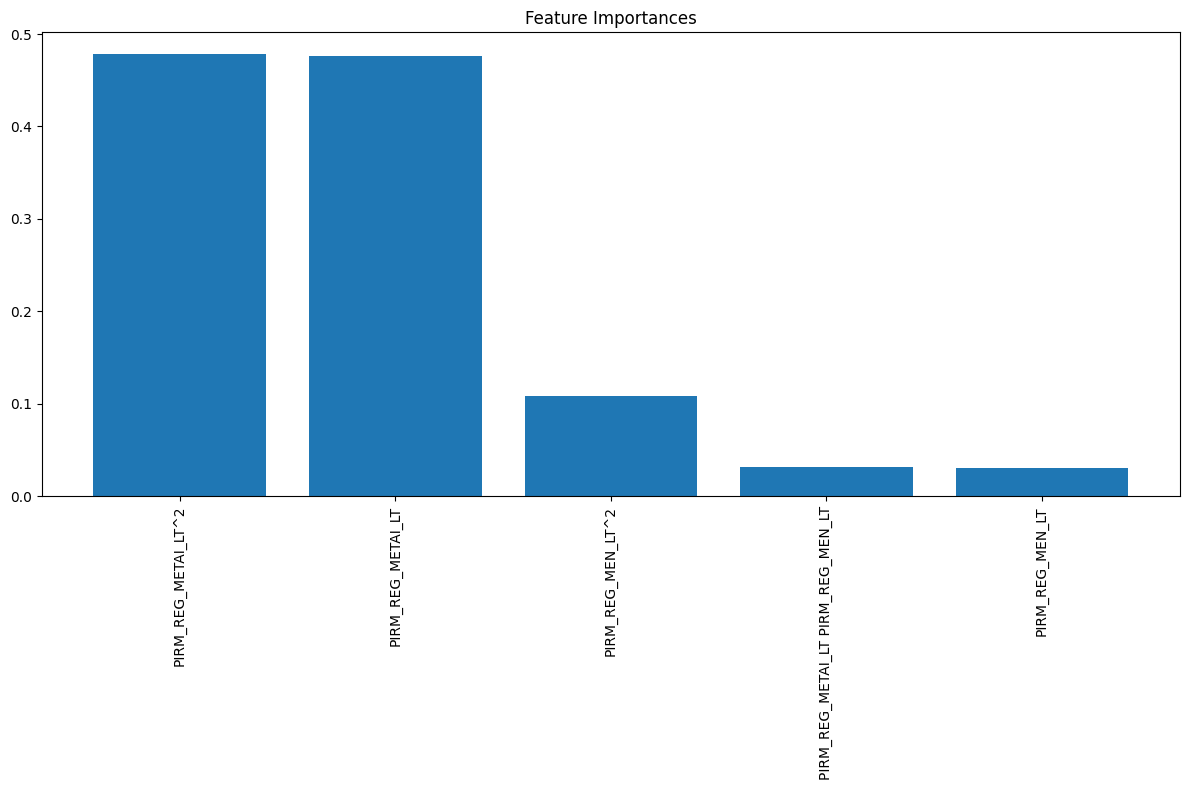

Geriausi parametrai: {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
Treniravimo MSE: 2652176.102753917
Testavimo MSE: 2766874.200689584
Treniravimo R2: 0.9042899540203287
Testavimo R2: 0.8965756078572624
Kryžminės validacijos (cv=5) R2 reikšmės: [0.89602669 0.8865216  0.9159072  0.91595069 0.89405816]
Kryžminės validacijos (cv=5) vidutinis R2: 0.9016928667788401
Kryžminės validacijos (cv=10) R2 reikšmės: [0.91159812 0.87062692 0.83881268 0.92160568 0.90725421 0.91990133
 0.91248938 0.92437409 0.87359569 0.90413854]
Kryžminės validacijos (cv=10) vidutinis R2: 0.8984396627588775


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import numpy as np

# Įkeliame duomenis iš pateikto failo
data = pd.read_csv('data_visi_v2.csv')

# Pasiruošiame duomenis
X = data.drop(columns=['KIEKIS'])
y = data['KIEKIS']

# Padalijame į treniravimo ir testavimo rinkinius
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sukuriame polinominius požymius
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Normalizuojame duomenis
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

# Sukuriame SVR regresorių
svr_regressor = SVR()

# Nustatome hiperparametrų tinklą
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Naudojame GridSearchCV geriausiems parametrams rasti
grid_search = GridSearchCV(estimator=svr_regressor, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_poly_scaled, y_train)

# Geriausi parametrai
best_params = grid_search.best_params_

# Geriausias modelis
best_model = grid_search.best_estimator_

# Atliekame prognozes su geriausiu modeliu
y_train_pred = best_model.predict(X_train_poly_scaled)
y_test_pred = best_model.predict(X_test_poly_scaled)

# Vertiname modelį
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Kryžminė validacija su pilnu duomenų rinkiniu
X_combined = pd.concat([X_train, X_test])
y_combined = pd.concat([y_train, y_test])
X_combined_poly = poly.fit_transform(X_combined)
X_combined_poly_scaled = scaler.fit_transform(X_combined_poly)

cv_scores_5 = cross_val_score(best_model, X_combined_poly_scaled, y_combined, cv=5, scoring='r2')
cv_scores_10 = cross_val_score(best_model, X_combined_poly_scaled, y_combined, cv=10, scoring='r2')

# Požymių svarbos vertinimas
result = permutation_importance(best_model, X_test_poly_scaled, y_test, n_repeats=10, random_state=42)
importance = result.importances_mean

# Požymių svarbos vizualizacija
features = poly.get_feature_names_out()
indices = np.argsort(importance)[::-1]
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(X_test_poly.shape[1]), importance[indices], align="center")
plt.xticks(range(X_test_poly.shape[1]), features[indices], rotation=90)
plt.tight_layout()
plt.show()

# Rezultatų spausdinimas
print(f'Geriausi parametrai: {best_params}')
print(f'Treniravimo MSE: {train_mse}')
print(f'Testavimo MSE: {test_mse}')
print(f'Treniravimo R2: {train_r2}')
print(f'Testavimo R2: {test_r2}')

print(f'Kryžminės validacijos (cv=5) R2 reikšmės: {cv_scores_5}')
print(f'Kryžminės validacijos (cv=5) vidutinis R2: {cv_scores_5.mean()}')

print(f'Kryžminės validacijos (cv=10) R2 reikšmės: {cv_scores_10}')
print(f'Kryžminės validacijos (cv=10) vidutinis R2: {cv_scores_10.mean()}')
